In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


In [2]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.99    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.1
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep Q-Learning
        model = tf.keras.Sequential()
        model.add(layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(24, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
      if len(self.memory) < batch_size:
          return  0

      minibatch_indices = np.random.choice(len(self.memory), batch_size, replace=False)
      minibatch = [self.memory[i] for i in minibatch_indices]

      losses=[]
      for state, action, reward, next_state, done in minibatch:
          target = reward
          if not done:
              target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
          target_f = self.model.predict(state)
          target_f[0][action] = target
          history = self.model.fit(state, target_f, epochs=1, verbose=0)
          losses.append(history.history['loss'][0])
      return np.mean(losses)  # Return the average loss

def one_hot_state(state):
    state_one_hot = np.zeros(state_size)
    state_one_hot[state] = 1
    return state_one_hot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = gym.make('Taxi-v3',new_step_api=True)
state_size = env.observation_space.n
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
episodes = 300
rewards_per_episode=[]
losses = []


for e in range(episodes):
    total_episode_reward=0
    state = env.reset()
    state = one_hot_state(state)
    state = np.reshape(state, [1, state_size])
    for time in range(500):
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated  # Consider episode done if either flag is True
        reward = reward if not done else -10
        next_state = one_hot_state(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        # Rest of the loop

        if done:
            print("episode: {}/{}, score: {}, e: {:.2}".format(e, episodes, time, agent.epsilon))
            break
    rewards_per_episode.append(total_episode_reward)  # Store the total reward

    if len(agent.memory) > 32:
        loss = agent.replay(32)
        losses.append(loss)  # Store the loss



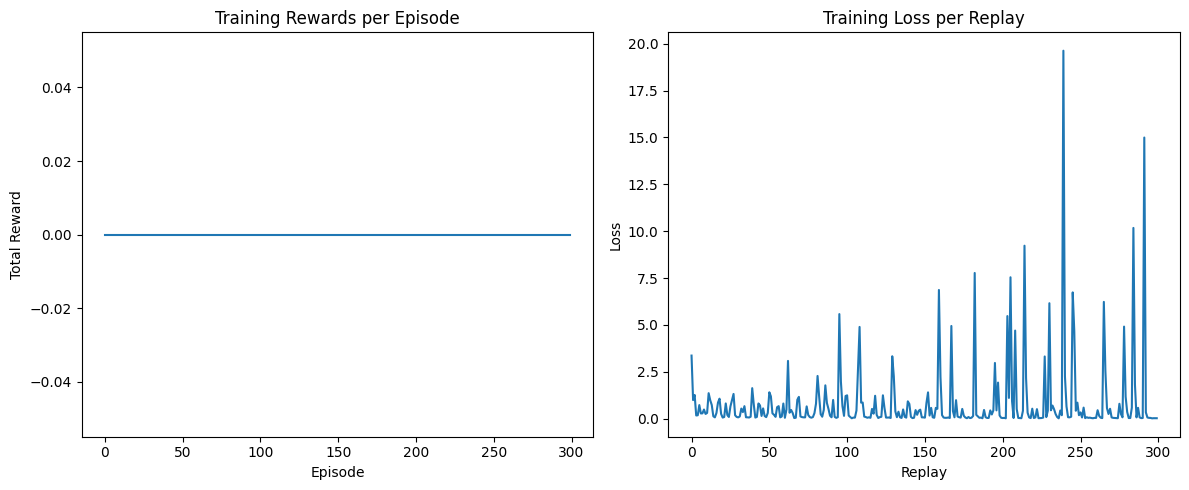

In [6]:
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards_per_episode)
plt.title('Training Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title('Training Loss per Replay')
plt.xlabel('Replay')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [ ]:
test_episodes = 30
test_rewards = []



for e in range(test_episodes):
    state = env.reset()
    state = one_hot_state(state, state_size)
    total_reward = 0

    for _ in range(500):
        action = np.argmax(agent.model.predict(state)[0])
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        next_state = one_hot_state(next_state, state_size)

        if done:
            break

    test_rewards.append(total_reward)

average_test_reward = np.mean(test_rewards)



In [5]:
print(f"Average Test Reward: {average_test_reward}")

Average Test Reward: -200.0
